In [70]:
import sys
stdout = sys.stdout
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_vector
from IPython.display import display, Markdown, Latex
from qiskit.providers.ibmq import least_busy

import warnings
warnings.simplefilter('ignore')

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$

In [71]:
#fix output
sys.stdout = stdout

In [72]:
def assert_correct_counts(counts, expected_value):
    keys = counts.keys()
    if len(keys) == 1 and expected_value == list(keys)[0]:
        print('✅ Correct prediction 🎉')
        return True
    else:
        print('❌ False assertion, maybe there are also more than 1 results! 😥')
        return False

def compile_circuit_and_check(circuit, expected_value, shots=3000, simulator = QasmSimulator()):
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    result = assert_correct_counts(counts, expected_value)
    return counts, result, list(counts.keys())[0]

def check_if_matrix_is_unitary(qubits, matrix):
    circuit = QuantumCircuit(qubits,qubits)
    try:
        circuit.unitary(addition, range(qubits), label="unitary check")
        print('✅ We got an unitary matrix! 🎉')
    except:
        print('❌ Input matrix is not unitary. 😥')
    

# Binary multiplier

The rules of basic binary multiplication are relatively simple.

$$
0 \times 0 =\ 0 \\
0 \times 1 =\ 0 \\
1 \times 0 =\ 0 \\
1 \times 1 =\ 1 \\
$$

As previously defined in the [_full adder evaluation_](full_adder_evaluation.ipynb), to construct a reversible matrix that can be used as a quantum gate we have to assert bijection. Using this information, we can construct the _state-matrix_ $S$ and the _output-matrix_ $O$.

$$
S = \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
        \end{pmatrix} \\
$$

$$
O = \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
        \end{pmatrix} \\
$$

The observant eye will have realized that something is wrong about the _output-matrix_ $O$, and you are quite right. To assert reversability, we have to make sure that our gate function is fully bijective. The problem arises, as soon as we get into the states $\ket{1xy}$. As we completely ignore the state of qubit 3 for the multiplication, we would have 2 _input-states_ that lead to the same _output-state_. Hence why we have to _assume_ that the third qubit is always 0 at the execution of the gate.

Using these 2 matrices, we can now build the _multiplication matrix_ $U_{multiplication}$.

$$
O * S^T =\ U_{multiplication} \\
$$
$$
U_{multiplication} = \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
        \end{pmatrix} \\
$$

Lets check it out using qiskit

In [73]:
multiplication = qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                              [0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 0]])

check_if_matrix_is_unitary(3, multiplication)

✅ We got an unitary matrix! 🎉


Now that we have confirmed that our $U_{multiplication}$ matrix is unitary, we can test it out with qiskit.


In [74]:
#creates a basic 3 qubit circuit to test the 3 qubit matrix Uadd

def generate_circuit(state):
    circuit = QuantumCircuit(3,3)
    for idx, val in enumerate(state):
        if val == 1:
            circuit.x(len(state)-1-idx)
    circuit.barrier()
    circuit.unitary(multiplication, [0, 1, 2], label='multiplication')
    circuit.barrier()
    circuit.measure(range(3),range(3)) 
    return circuit

print('Circuit depth: ' + str(generate_circuit([0,1]).decompose().depth()))

Circuit depth: 3


Note that we have 3 qubits because we have to fulfill the requirements for quantum gates. One of these is reversability. As seen in the first paragraph, we have to set the output on an additional qubit to make the circuit reversible!

Testing for initial state [0, 0] and expected measurment state 000


░ ┌─────────────────┐ ░ ┌─┐      
q_0: ─░─┤0                ├─░─┤M├──────
      ░ │                 │ ░ └╥┘┌─┐   
q_1: ─░─┤1 multiplication ├─░──╫─┤M├───
      ░ │                 │ ░  ║ └╥┘┌─┐
q_2: ─░─┤2                ├─░──╫──╫─┤M├
      ░ └─────────────────┘ ░  ║  ║ └╥┘
c: 3/══════════════════════════╩══╩══╩═
                               0  1  2

✅ Correct prediction 🎉


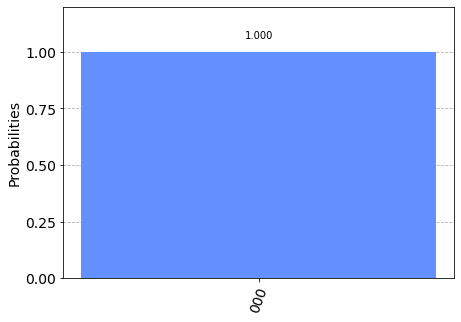

Testing for initial state [0, 1] and expected measurment state 001


┌───┐ ░ ┌─────────────────┐ ░ ┌─┐      
q_0: ┤ X ├─░─┤0                ├─░─┤M├──────
     └───┘ ░ │                 │ ░ └╥┘┌─┐   
q_1: ──────░─┤1 multiplication ├─░──╫─┤M├───
           ░ │                 │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2                ├─░──╫──╫─┤M├
           ░ └─────────────────┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════════╩══╩══╩═
                                    0  1  2

✅ Correct prediction 🎉


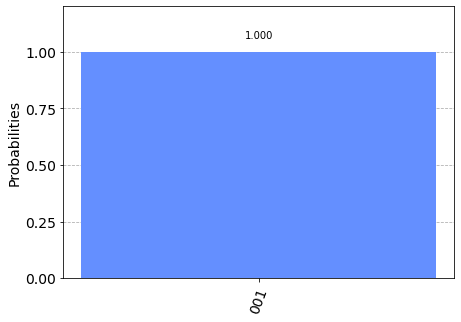

Testing for initial state [1, 0] and expected measurment state 010


░ ┌─────────────────┐ ░ ┌─┐      
q_0: ──────░─┤0                ├─░─┤M├──────
     ┌───┐ ░ │                 │ ░ └╥┘┌─┐   
q_1: ┤ X ├─░─┤1 multiplication ├─░──╫─┤M├───
     └───┘ ░ │                 │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2                ├─░──╫──╫─┤M├
           ░ └─────────────────┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════════╩══╩══╩═
                                    0  1  2

✅ Correct prediction 🎉


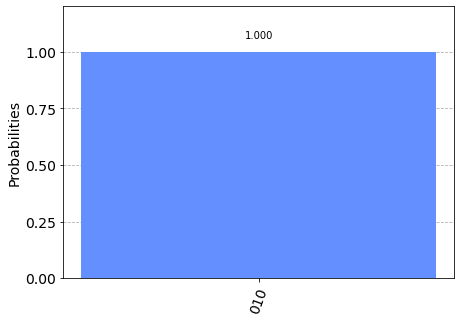

Testing for initial state [1, 1] and expected measurment state 111


┌───┐ ░ ┌─────────────────┐ ░ ┌─┐      
q_0: ┤ X ├─░─┤0                ├─░─┤M├──────
     ├───┤ ░ │                 │ ░ └╥┘┌─┐   
q_1: ┤ X ├─░─┤1 multiplication ├─░──╫─┤M├───
     └───┘ ░ │                 │ ░  ║ └╥┘┌─┐
q_2: ──────░─┤2                ├─░──╫──╫─┤M├
           ░ └─────────────────┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════════╩══╩══╩═
                                    0  1  2

✅ Correct prediction 🎉


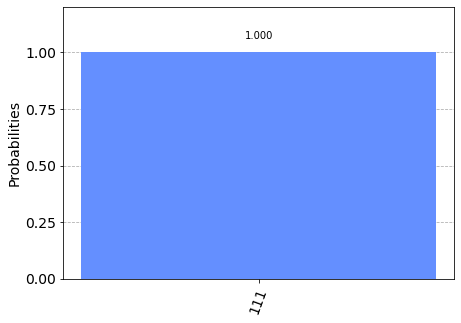

In [75]:
#creates static states to assert the matrix works correctly
state_matrix = [[0,0],
                [0,1],
                [1,0],
                [1,1]]

#note that the MSB is the "output" bit C, and the LSB is the input bit A, the middle bit the input bit B
#so we are doing A + B = C
#MSB being the leftmost bit
expected_states = [ '000',
                    '001',
                    '010',
                    '111']

for index, expected_state in enumerate(expected_states):
    print("Testing for initial state " + str(state_matrix[index]) + " and expected measurment state " + expected_state)
    circuit = generate_circuit(state_matrix[index])
    display(circuit.draw())
    counts, result, _ = compile_circuit_and_check(circuit, expected_states[index])
    display(plot_histogram(counts))

As we can see, our selfmade addition matrix $U_{multiplication}$ works correctly, as proven trough the simulator.

### n-bit wide multiplication

To multiply bitwords larger than 1, we have to check the rules of binary multiplication. 

<center>
<img src="https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/binary-multiplication-example-1-1623819040.png" />

<em>Image 1: <a href="https://www.cuemath.com/numbers/binary-multiplication/">Binary multiplication of 110 x 11</a></em>
</center>


For $a*b =\ c$, we multiple $a$ by each bit of $b$, starting with the LSB (rightmost bit). 
After each bit of $b$, we add a placeholder and continue on the next row. After mutliplying each bit of $b$, we can add together all partial products to receive $c$. To further test our theory, we will construct multiplier that can multiply two 2-wide bitwords together. For this, we will need the addition matrix as well as the carry over circuit of the previous chapter.

In [76]:
addition = qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])

def get_carry_over_circuit():
    sub_circuit = QuantumRegister(4)
    carry_out = QuantumCircuit(sub_circuit, name="carry over")
    carry_out.ccx(0,1,3)
    carry_out.ccx(1,2,3)
    carry_out.ccx(0,2,3)
    return carry_out

We also have to consider the output. Whilst the output for the multiplication of two 1 bit wide words is again 1 bit wide, for 2 bits we can have up to a 4 bit wide word. We can prove this with the following code:

In [77]:
print(bin(3))
print(bin(3))
print(bin(3*3))

0b11
0b11
0b1001


In [78]:
#adapt function to add
def generate_circuit(state):
    circuit = QuantumCircuit(12,4)
    if state[1] == 1:
        circuit.x(0)
    if state[0] == 1:
        circuit.x(1)
    if state[3] == 1:
        circuit.x(2)
    if state[2] == 1:
        circuit.x(3)
    circuit.barrier()
    circuit.unitary(multiplication, [0, 2, 4], label='multiplication')
    circuit.unitary(multiplication, [0, 3, 5], label='multiplication')
    circuit.unitary(multiplication, [1, 2, 6], label='multiplication')
    circuit.unitary(multiplication, [1, 3, 7], label='multiplication')
    circuit.measure(4,0)
    circuit.append(get_carry_over_circuit(), [5, 6, 8, 9])
    circuit.unitary(addition, [5, 6, 8], label='addition')
    circuit.measure(8,1)
    circuit.append(get_carry_over_circuit(), [7, 9, 10, 11])
    circuit.unitary(addition, [7, 9, 10], label= 'addition')
    circuit.measure(10,2)
    circuit.measure(11,3)
    return circuit

#full adder sub circuit
def create_full_adder(nbits):
    if nbits < 1:
        raise Exception('You can\'t add less than 1 bit together!')
    n = 3 * nbits + 1
    if n < 4: n = 4
    circuit = QuantumCircuit(n,nbits)
    parameters = create_parameters(2*nbits)
    iterparam = parameters.copy()
    circuit.rx(iterparam[0],0)
    circuit.rx(iterparam[1],1)
    del iterparam[0:2]
    iterable_parameters = iter(iterparam)
    for i in range(4,n):
        if i%3 == 0:
            continue
        else:
            circuit.rx(next(iterable_parameters),i)
    circuit.barrier()
    #start the circuitry

    for i in range(nbits):
        if i == 0:
            circuit.append(get_carry_over_circuit(), [0, 1, 2, 3])
            circuit.unitary(get_adder_circuit(), [0, 1, 2], label='addition')
            circuit.measure(2,0)
        else:
            circuit.append(get_carry_over_circuit(), [i*3+1, i*3+2, i*3, i*3+3])
            circuit.unitary(get_adder_circuit(), [i*3+1, i*3+2, i*3], label='addition')
            circuit.measure(i*3,i)

    return circuit

In [79]:
def test_full_multiplier():
    n = 2 # width of input bitwords
    # contains both input words 
    # [a1, a0, b1, b0]
    state_matrix = [[0,0,0,0],
                    [0,0,0,1],
                    [0,0,1,0],
                    [0,0,1,1],
                    [0,1,0,0],
                    [0,1,0,1],
                    [0,1,1,0],
                    [0,1,1,1],
                    [1,0,0,0],
                    [1,0,0,1],
                    [1,0,1,0],
                    [1,0,1,1],
                    [1,1,0,0],
                    [1,1,0,1],
                    [1,1,1,0],
                    [1,1,1,1]]

    results = []

    for index, state in enumerate(state_matrix):
        a = int(str(state[0]) + str(state[1]), 2)
        b = int(str(state[2]) + str(state[3]), 2)
        c = bin(a*b).replace('0b','')
        while len(c) < n*2:
            c = '0' + c
        circuit = generate_circuit(state)
        counts, result, ccalculated = compile_circuit_and_check(circuit, c)
        print(counts)
        results.append([bin(a).replace('0b',''), bin(b).replace('0b',''), c, ccalculated, '✅' if result else '❌'])

    display(Markdown('|Ain | Bin | Cexpected | Ccalculated | Result |\n'+'|:---:|:---:|:-----:|:------:|--------|\n'+''.join(['|'+val[0]+'|'+val[1]+'|'+val[2]+'|'+val[3]+'|'+val[4]+'|\n' for val in results])))

test_full_multiplier()

✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0001': 3000}
✅ Correct prediction 🎉
{'0010': 3000}
✅ Correct prediction 🎉
{'0011': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0010': 3000}
✅ Correct prediction 🎉
{'0100': 3000}
✅ Correct prediction 🎉
{'0110': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0011': 3000}
✅ Correct prediction 🎉
{'0110': 3000}
✅ Correct prediction 🎉
{'1001': 3000}


|Ain | Bin | Cexpected | Ccalculated | Result |
|:---:|:---:|:-----:|:------:|--------|
|0|0|0000|0000|✅|
|0|1|0000|0000|✅|
|0|10|0000|0000|✅|
|0|11|0000|0000|✅|
|1|0|0000|0000|✅|
|1|1|0001|0001|✅|
|1|10|0010|0010|✅|
|1|11|0011|0011|✅|
|10|0|0000|0000|✅|
|10|1|0010|0010|✅|
|10|10|0100|0100|✅|
|10|11|0110|0110|✅|
|11|0|0000|0000|✅|
|11|1|0011|0011|✅|
|11|10|0110|0110|✅|
|11|11|1001|1001|✅|


## Quantum circuit depth and width

Current quantum hardware is strongly limited by the amount of avaliable qubit lanes as well as the possible gate depth. In addition to these limitations, the current problem of ever increasing noise and errors with gate depth means that the current usability is highly tied to the complexity of the circuitry. If we go by the current circuit to add two 2-wide bitwords together, we get the following numbers:

$$
A_{width} =\ B_{width} = 2\\
C_{width} =\ A_{width} + B_{width} =\ 4\\
Interim_{width} =\  C_{width} =\ 4\\
n =\ A_{width}  +B_{width} + C_{width} + Interim_{width} = 12\\
n = A_{width}*2 * 3 =\ 6A_{width}\\
$$

Going from this example, if we want to multiply two 8 bit wide bitwords, we'd have to construct a _48 qubit_ wide circuit. To calculate the depth we have to take a look at the _decomposed_ circuit, as it shows the single gates used:

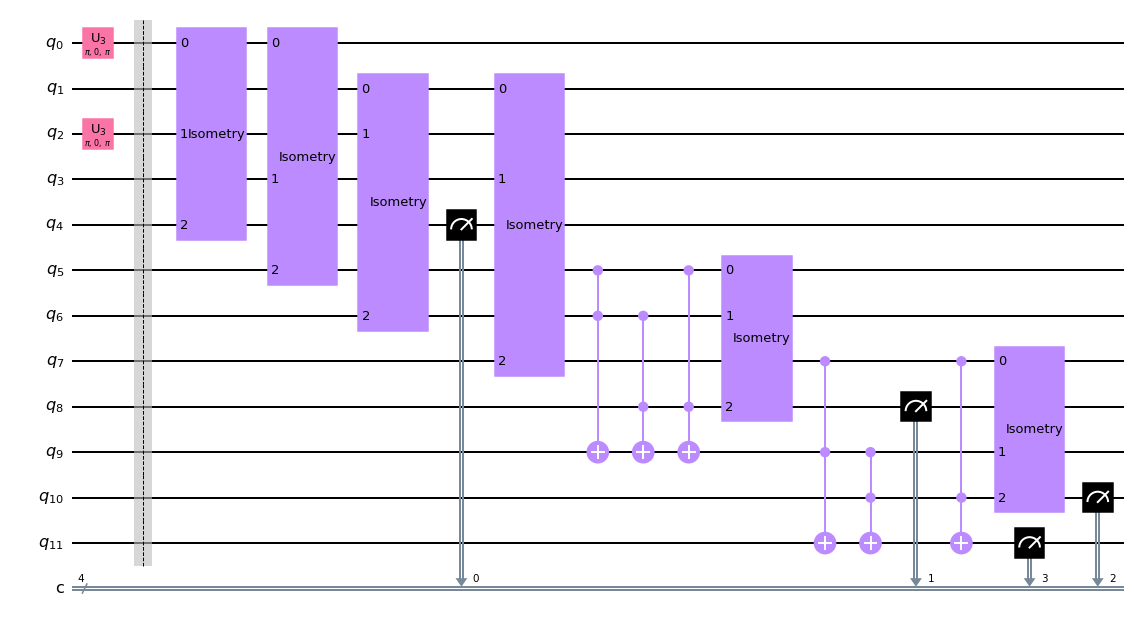

Circuit depth: 11


In [80]:
circuit = generate_circuit([0,1,0,1]).decompose()
display(circuit.draw('mpl'))
print('Circuit depth: ' + str(circuit.depth()))

As defined in the previous chapter, we know that we can reuse the $C_{out}$ qubit as $C_{in}$ in the next adder, which helps _a bit_ but not much in the wider picture. During the tests of the 1 wide multiplier, the depth was only 3. So by only doubling the _width_ of the input, we quadrupled the amount of needed qubits. The depth follows closely: its value has now more than tripled.

The full adder also grows, but at a much lower speed. For 1 bit wide input, we only need 4 qubits (if we use a full adder, that means we have a carry over qubit). But for 2 bit wide input, we need 7, so we nearly doubled the amount needed. The depth of a 1 bit wide full adder is 6, whilst the one of a 2 bit wide full adder is 8, thanks to the reusability of the $C_{out}$ qubit.

To help reduce the amount of qubits needed, we could [use measured, and therefor reset qubits, again](https://www.ibm.com/blogs/research/2021/02/quantum-mid-circuit-measurement/) in the circuit. This has the ability to reduce the amount of needed qubits, but increases the depth of the circuit. To create a comparison, we will try to build the 2 wide bit multiplier circuit by reusing measured qubits.

In [81]:
#adapt function to reuse measured qubits
def generate_circuit(state):
    circuit = QuantumCircuit(10,4)
    if state[1] == 1:
        circuit.x(0)
    if state[0] == 1:
        circuit.x(1)
    if state[3] == 1:
        circuit.x(2)
    if state[2] == 1:
        circuit.x(3)
    circuit.barrier()
    circuit.unitary(multiplication, [0, 2, 4], label='multiplication')
    circuit.unitary(multiplication, [0, 3, 5], label='multiplication')
    circuit.unitary(multiplication, [1, 2, 6], label='multiplication')
    circuit.unitary(multiplication, [1, 3, 7], label='multiplication')
    circuit.measure(4,0)
    circuit.append(get_carry_over_circuit(), [5, 6, 4, 8])
    circuit.unitary(addition, [5, 6, 4], label='addition')
    circuit.measure(4,1)
    circuit.append(get_carry_over_circuit(), [7, 8, 4, 9])
    circuit.unitary(addition, [7, 8, 4], label= 'addition')
    circuit.measure(4,2)
    circuit.measure(9,3)
    return circuit

✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'0111': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'0110': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'0101': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'0110': 3000}
✅ Correct prediction 🎉
{'0100': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'1010': 3000}
✅ Correct prediction 🎉
{'0000': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'0101': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'1010': 3000}
❌ False assertion, maybe there are also more than 1 results! 😥
{'1111': 3000}


|Ain | Bin | Cexpected | Ccalculated | Result |
|:---:|:---:|:-----:|:------:|--------|
|0|0|0000|0000|✅|
|0|1|0000|0000|✅|
|0|10|0000|0000|✅|
|0|11|0000|0000|✅|
|1|0|0000|0000|✅|
|1|1|0001|0111|❌|
|1|10|0010|0110|❌|
|1|11|0011|0101|❌|
|10|0|0000|0000|✅|
|10|1|0010|0110|❌|
|10|10|0100|0100|✅|
|10|11|0110|1010|❌|
|11|0|0000|0000|✅|
|11|1|0011|0101|❌|
|11|10|0110|1010|❌|
|11|11|1001|1111|❌|


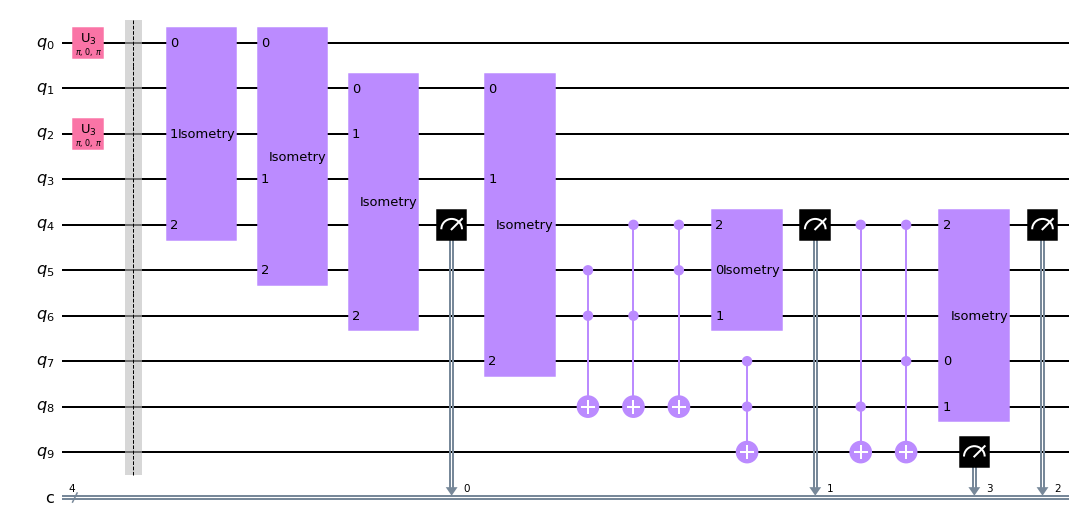

Circuit depth: 12


In [82]:
test_full_multiplier()

circuit = generate_circuit([0,1,0,1]).decompose()
display(circuit.draw('mpl'))
print('Circuit depth: ' + str(circuit.depth()))

With this we were able to reduce the amount of needed qubits by 2 to 10 only. At the same time, _according to qiskit_, the depth increased by _1_. It is unclear why this is the case, but the current assumption is that _measuring and reusing_ a qubit means it adds an overhead to the lane because the qubit has to be reset to an initial state again.

At the same time, the _simulator_ is now outputting wrong calculations. Any addition of [barriers](https://quantumcomputing.stackexchange.com/a/8371) or [rx(0*pi)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) gates have brought us no gain. What if we try it in the cloud? The current problem is, that there is no avaliable hardware to run the circuit on.